<a href="https://colab.research.google.com/github/CaptainLight5/Emotion-Prediction/blob/main/Emotion_Prediction_with_Transformer_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This Loads datasets
train_data = pd.read_csv('/content/WASSA23_essay_level_with_labels_train.tsv', sep='\t')
dev_data = pd.read_csv('/content/WASSA23_essay_level_dev.tsv', sep='\t')
test_data = pd.read_csv('/content/WASSA23_essay_level_test.tsv', sep='\t')
goldstandard_dev = pd.read_csv('/content/goldstandard_dev.tsv', sep='\t')


In [8]:
# EDA 1: Summary statistics and distribution of target labels
print(train_data.describe())


       conversation_id  article_id     empathy    distress  speaker_id  \
count       792.000000  792.000000  792.000000  792.000000  792.000000   
mean        257.669192  187.744949    4.239899    3.782513   28.968434   
std         141.438695  125.756364    2.014705    2.053606   15.026660   
min           2.000000    3.000000    1.000000    1.000000    0.000000   
25%         139.750000   71.000000    2.333333    1.750000   19.000000   
50%         260.500000  171.000000    4.666667    3.875000   25.000000   
75%         375.500000  301.000000    6.000000    6.000000   43.000000   
max         500.000000  417.000000    7.000000    7.000000   58.000000   

       speaker_number    essay_id  
count      792.000000  792.000000  
mean         1.500000  506.669192  
std          0.500316  287.374178  
min          1.000000    1.000000  
25%          1.000000  259.750000  
50%          1.500000  500.000000  
75%          2.000000  759.250000  
max          2.000000  999.000000  


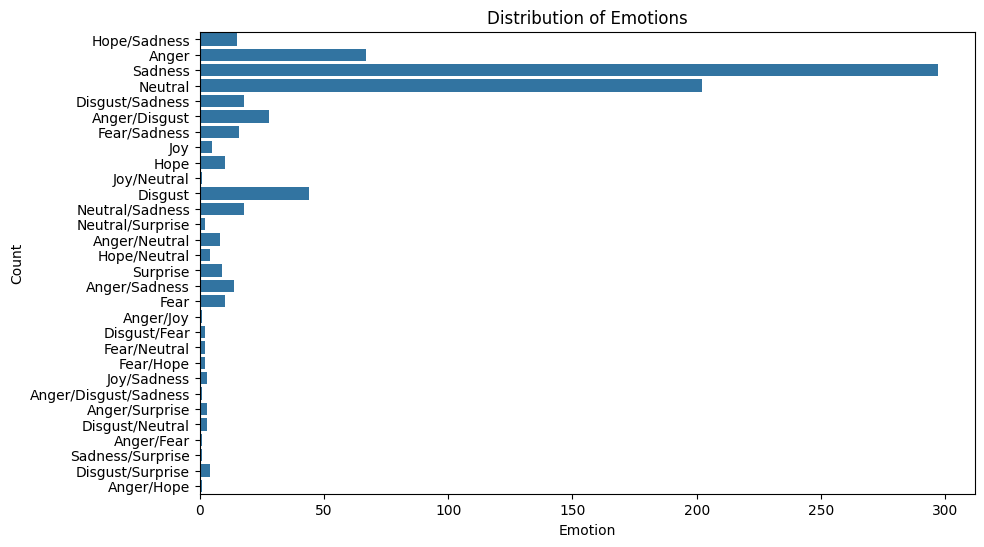

In [5]:
# EDA 2: Distribution of Emotions
plt.figure(figsize=(10, 6))
sns.countplot(train_data['emotion'])
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

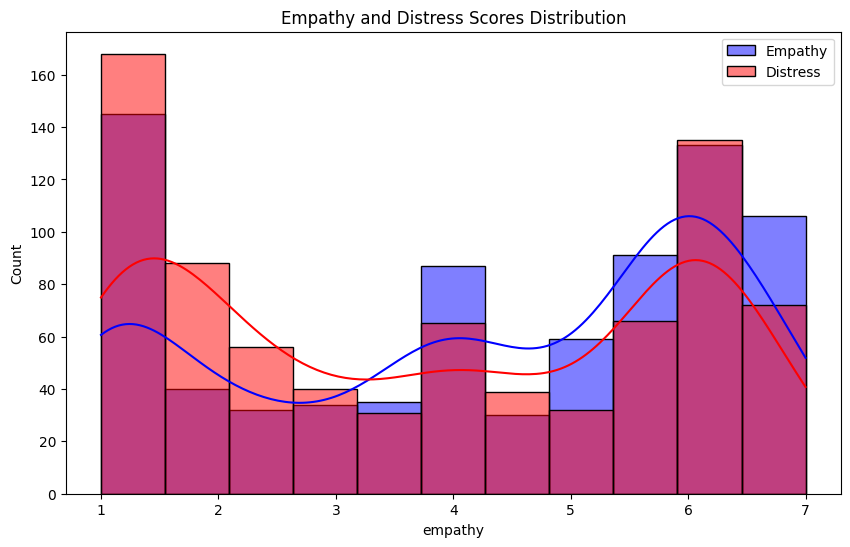

In [7]:
## EDA 3: Empathy and Distress Scores
plt.figure(figsize=(10, 6))
sns.histplot(train_data['empathy'], kde=True, color='blue', label='Empathy')
sns.histplot(train_data['distress'], kde=True, color='red', label='Distress')
plt.title('Empathy and Distress Scores Distribution')
plt.legend()
plt.show()

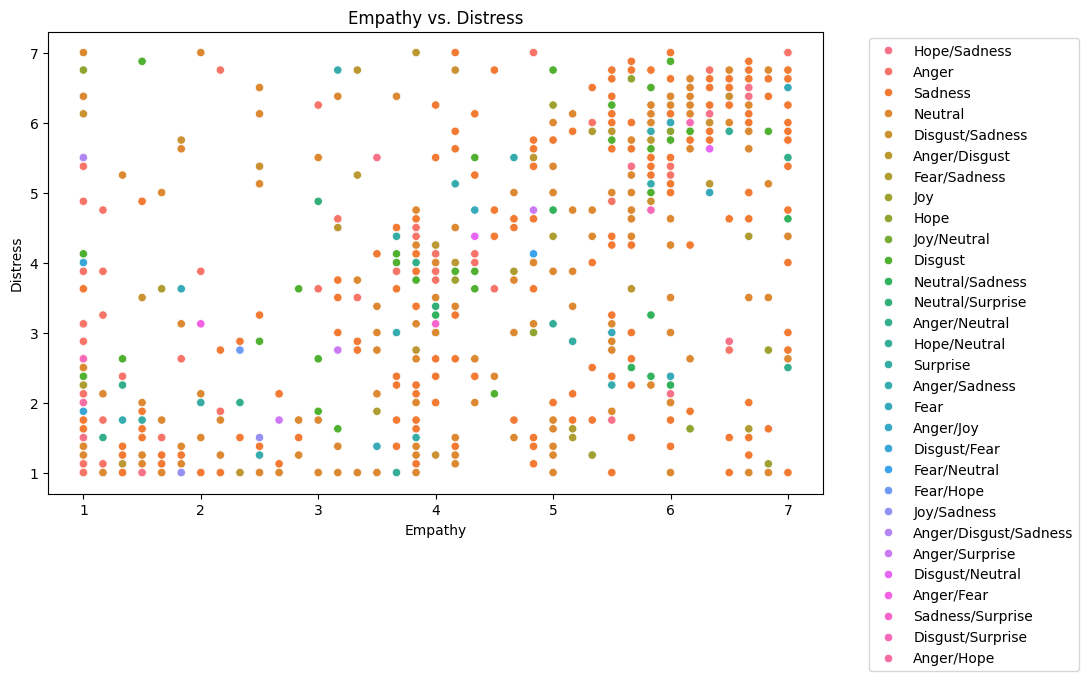

In [ ]:
# EDA 4: Empathy vs. Distress
plt.figure(figsize=(10, 6))
sns.scatterplot(x='empathy', y='distress', hue='emotion', data=data)
plt.title('Empathy vs. Distress')
plt.xlabel('Empathy')
plt.ylabel('Distress')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

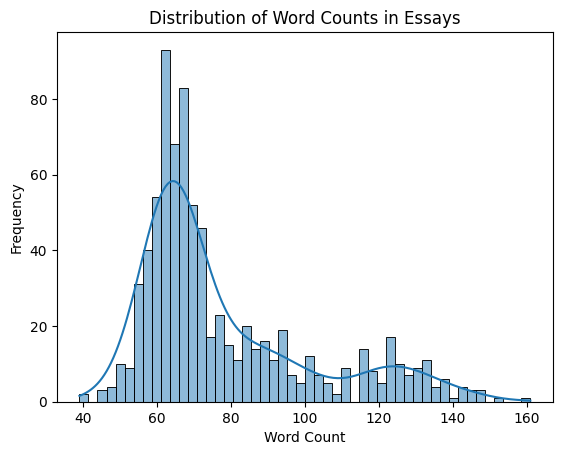

In [12]:

# EDA 4: Word count distribution
train_data['word_count'] = train_data['essay'].apply(lambda x: len(x.split()))
sns.histplot(train_data['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts in Essays')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

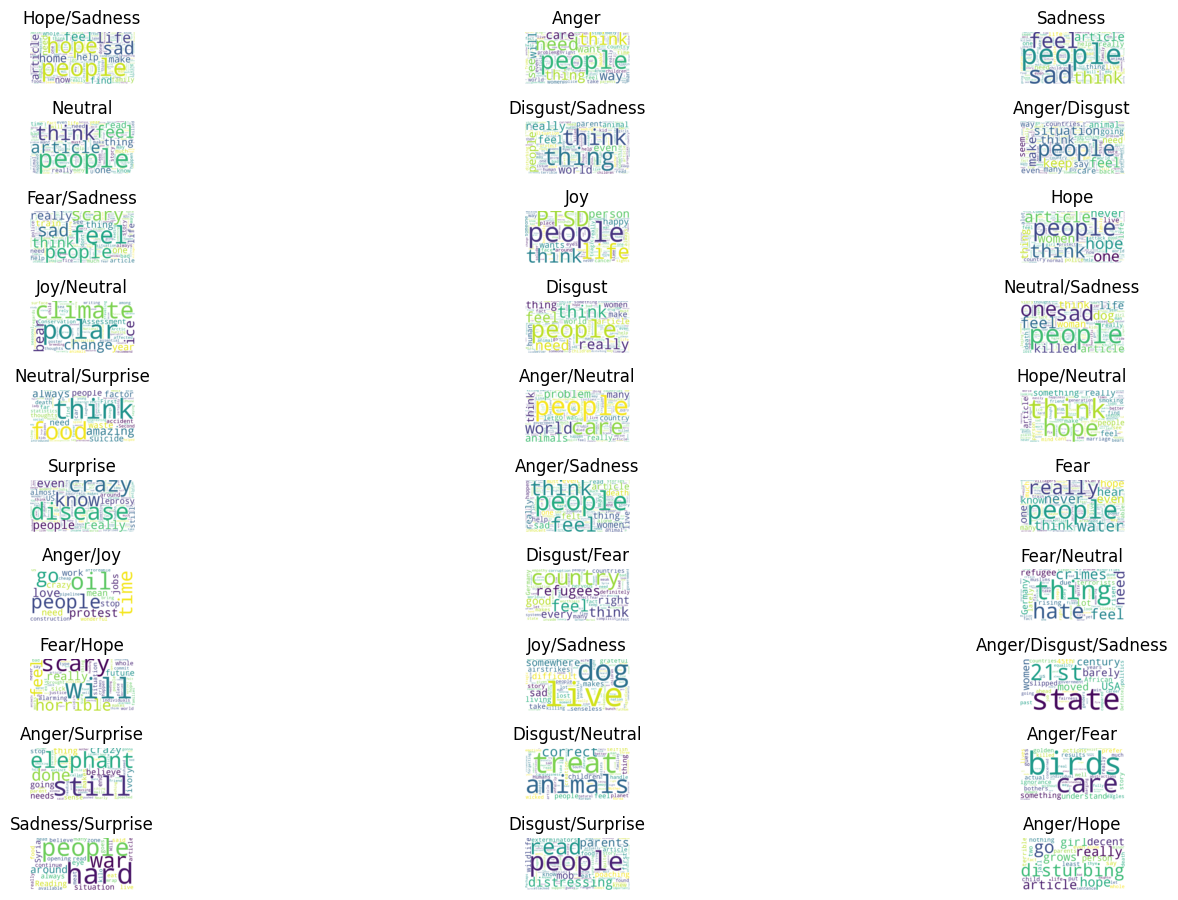

In [24]:
from wordcloud import WordCloud
# EDA - Word Cloud for each Emotion
emotions = train_data['emotion'].unique()
num_emotions = len(emotions)

plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotions):
    plt.subplot((num_emotions // 3) + 1, 3, i + 1)
    emotion_text = ' '.join(train_data[train_data['emotion'] == emotion]['essay'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(emotion)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# EDA 5: Most common words in the dataset
from collections import Counter
all_words = ' '.join(train_data['essay']).split()
common_words = [word for word, count in Counter(all_words).most_common(20)]
print("Most common words in the dataset:", common_words)

Most common words in the dataset: ['the', 'to', 'and', 'I', 'that', 'is', 'a', 'of', 'in', 'are', 'for', 'this', 'it', 'be', 'people', 'they', 'have', 'just', 'was', 'so']


In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import re

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Data cleaning function
def clean_text(text):
  # this removes the punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
     # here I converted the text to lowercase
    text = text.lower()
    return text

# Apply cleaning
train_data['clean_essay'] = train_data['essay'].apply(clean_text)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
train_data['tokens'] = train_data['clean_essay'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Here we Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data['clean_essay'], train_data['emotion'], test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
# The word Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Word2Vec Embeddings
word2vec_model = api.load("glove-wiki-gigaword-100")
def get_word2vec_embeddings(text):
    tokens = word_tokenize(text)
    embeddings = [word2vec_model[word] for word in tokens if word in word2vec_model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)

X_train_w2v = np.array([get_word2vec_embeddings(text) for text in X_train])
X_val_w2v = np.array([get_word2vec_embeddings(text) for text in X_val])


[==================================================] 100.0% 128.1/128.1MB downloaded


In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection using ANOVA F-test for the TF-IDF features
selector = SelectKBest(f_classif, k=3000)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_val_tfidf_selected = selector.transform(X_val_tfidf)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

# Here we Prepare dataset for transformers
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # this ensures all sequences are padded to the same length
            truncation=True, # this truncate sequences longer than max_length
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizers and encoders
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Fit LabelEncoder on all unique labels
label_encoder = LabelEncoder()
all_labels = pd.concat([y_train, y_val]).unique() # GThis gets all unique labels from both train and validation sets
label_encoder.fit(all_labels) # Fit the encoder on all labels

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
# This Creates dataset objects for BERT
train_dataset_bert = EmotionDataset(X_train.tolist(), y_train_encoded, bert_tokenizer, max_len=128)
val_dataset_bert = EmotionDataset(X_val.tolist(), y_val_encoded, bert_tokenizer, max_len=128)

# DataLoader for BERT
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)

In [15]:
# Here we Define the BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# this is the Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=10,
)

# this is the Function to compute the evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer for BERT
trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics
)

# Train BERT model
trainer_bert.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.356000
20,3.276800
30,3.172500
40,3.105800
50,3.061300
60,2.969900
70,2.695800
80,2.663900
90,2.424300
100,2.376100


TrainOutput(global_step=400, training_loss=1.7987641215324401, metrics={'train_runtime': 7875.2628, 'train_samples_per_second': 0.804, 'train_steps_per_second': 0.051, 'total_flos': 416477921633280.0, 'train_loss': 1.7987641215324401, 'epoch': 10.0})

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Evaluate BERT model
results_bert = trainer_bert.evaluate()
print("BERT Results:", results_bert)


BERT Results: {'eval_loss': 2.1606054306030273, 'eval_accuracy': 0.4339622641509434, 'eval_f1': 0.2940258159369541, 'eval_precision': 0.3383458646616541, 'eval_recall': 0.4339622641509434, 'eval_runtime': 77.7573, 'eval_samples_per_second': 2.045, 'eval_steps_per_second': 0.129, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Create dataset objects for RoBERTa
train_dataset_roberta = EmotionDataset(X_train.tolist(), y_train_encoded, roberta_tokenizer, max_len=128)
val_dataset_roberta = EmotionDataset(X_val.tolist(), y_val_encoded, roberta_tokenizer, max_len=128)

# DataLoader for RoBERTa
train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=16, shuffle=True)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=16)


In [17]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Training arguments for RoBERTa
training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=10,
)

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



# Trainer for RoBERTa
trainer_roberta = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics
)

# Train RoBERTa model
trainer_roberta.train()

# Evaluate RoBERTa model
results_roberta = trainer_roberta.evaluate()
print("RoBERTa Results:", results_roberta)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.440000
20,3.414100
30,3.389100
40,3.344100
50,3.245400
60,2.993800
70,2.408600
80,2.371500
90,2.225200
100,2.237100


Step,Training Loss
10,3.440000
20,3.414100
30,3.389100
40,3.344100
50,3.245400
60,2.993800
70,2.408600
80,2.371500
90,2.225200
100,2.237100


RoBERTa Results: {'eval_loss': 1.805086374282837, 'eval_accuracy': 0.5786163522012578, 'eval_f1': 0.5259161404303704, 'eval_precision': 0.4950271407294468, 'eval_recall': 0.5786163522012578, 'eval_runtime': 61.0138, 'eval_samples_per_second': 2.606, 'eval_steps_per_second': 0.164, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


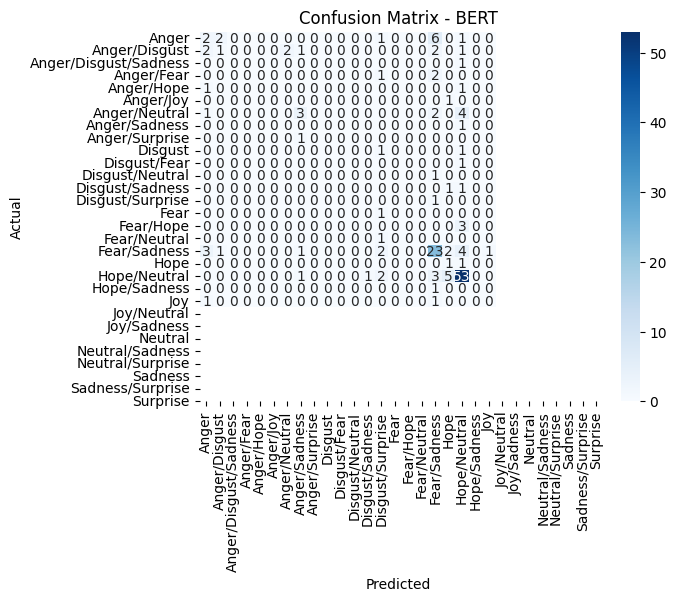

In [33]:
# Confusion Matrix for BERT
preds_bert = trainer_bert.predict(val_dataset_bert)
cm_bert = confusion_matrix(preds_bert.label_ids, preds_bert.predictions.argmax(-1))

# Get emotion labels from the label encoder
emotion_labels = label_encoder.classes_

# Plot confusion matrix with emotion labels
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


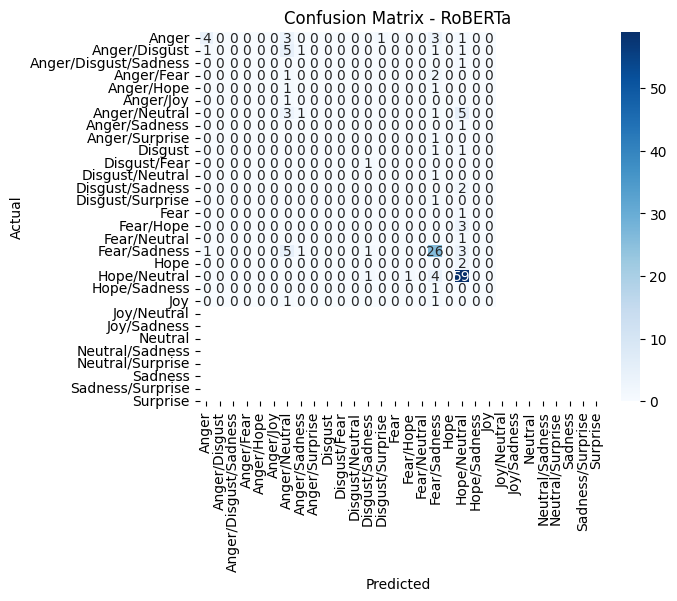

In [34]:
# Confusion Matrix for RoBERTa
preds_roberta = trainer_roberta.predict(val_dataset_roberta)
cm_roberta = confusion_matrix(preds_roberta.label_ids, preds_roberta.predictions.argmax(-1))

# Get emotion labels (make sure label_encoder is defined)
emotion_labels = label_encoder.classes_

# Plot confusion matrix with emotion labels
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix - RoBERTa')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [58]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 100

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Combine labels for encoding
combined_labels = pd.concat([y_train, y_val])

# Encode labels using the combined labels
label_encoder = LabelEncoder()
label_encoder.fit(combined_labels)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert to categorical for LSTM
y_train_encoded_cat = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_encoded_cat = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))



In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training of the model
history = lstm_model.fit(X_train_pad, y_train_encoded_cat, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_encoded_cat))


Epoch 1/10
20/20 [==============================] - 19s 602ms/step - loss: 3.0020 - accuracy: 0.3207 - val_loss: 2.1327 - val_accuracy: 0.4088
Epoch 2/10
20/20 [==============================] - 10s 476ms/step - loss: 2.1318 - accuracy: 0.3333 - val_loss: 2.0553 - val_accuracy: 0.4088
Epoch 3/10
20/20 [==============================] - 5s 272ms/step - loss: 2.0842 - accuracy: 0.3665 - val_loss: 2.0636 - val_accuracy: 0.4088
Epoch 4/10
20/20 [==============================] - 7s 342ms/step - loss: 2.0618 - accuracy: 0.3744 - val_loss: 2.0604 - val_accuracy: 0.4088
Epoch 5/10
20/20 [==============================] - 5s 268ms/step - loss: 2.0326 - accuracy: 0.3728 - val_loss: 2.0641 - val_accuracy: 0.4088
Epoch 6/10
20/20 [==============================] - 6s 291ms/step - loss: 1.9740 - accuracy: 0.4360 - val_loss: 2.0469 - val_accuracy: 0.4151
Epoch 7/10
20/20 [==============================] - 7s 334ms/step - loss: 1.8461 - accuracy: 0.5324 - val_loss: 2.0339 - val_accuracy: 0.4088
Epoc

In [63]:
# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_val_pad, y_val_encoded_cat)
print(f'LSTM Validation Accuracy: {accuracy * 100:.2f}%')

# Predict on validation data
y_val_pred_lstm = lstm_model.predict(X_val_pad)
y_val_pred_lstm_classes = y_val_pred_lstm.argmax(axis=-1)
y_val_true_classes = y_val_encoded

# Finds unique classes in TRUE labels
unique_classes_true = set(y_val_true_classes)

# Filter label encoder classes to match TRUE classes
filtered_labels = [label for i, label in enumerate(label_encoder.classes_) if i in unique_classes_true]

# Classification report
from sklearn.metrics import classification_report
report_lstm = classification_report(y_val_true_classes, y_val_pred_lstm_classes, target_names=filtered_labels)
print("LSTM Classification Report:\n", report_lstm)

5/5 [==============================] - 0s 72ms/step - loss: 2.3293 - accuracy: 0.4088
LSTM Validation Accuracy: 40.88%
5/5 [==============================] - 0s 79ms/step
LSTM Classification Report:
                   precision    recall  f1-score   support

           Anger       0.09      0.17      0.12        12
   Anger/Disgust       0.00      0.00      0.00         9
      Anger/Hope       0.00      0.00      0.00         1
   Anger/Neutral       0.00      0.00      0.00         3
   Anger/Sadness       0.00      0.00      0.00         2
  Anger/Surprise       0.00      0.00      0.00         1
         Disgust       0.22      0.20      0.21        10
 Disgust/Sadness       0.00      0.00      0.00         1
Disgust/Surprise       0.00      0.00      0.00         1
            Fear       0.00      0.00      0.00         2
       Fear/Hope       0.00      0.00      0.00         1
    Fear/Neutral       0.00      0.00      0.00         1
    Fear/Sadness       0.00      0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


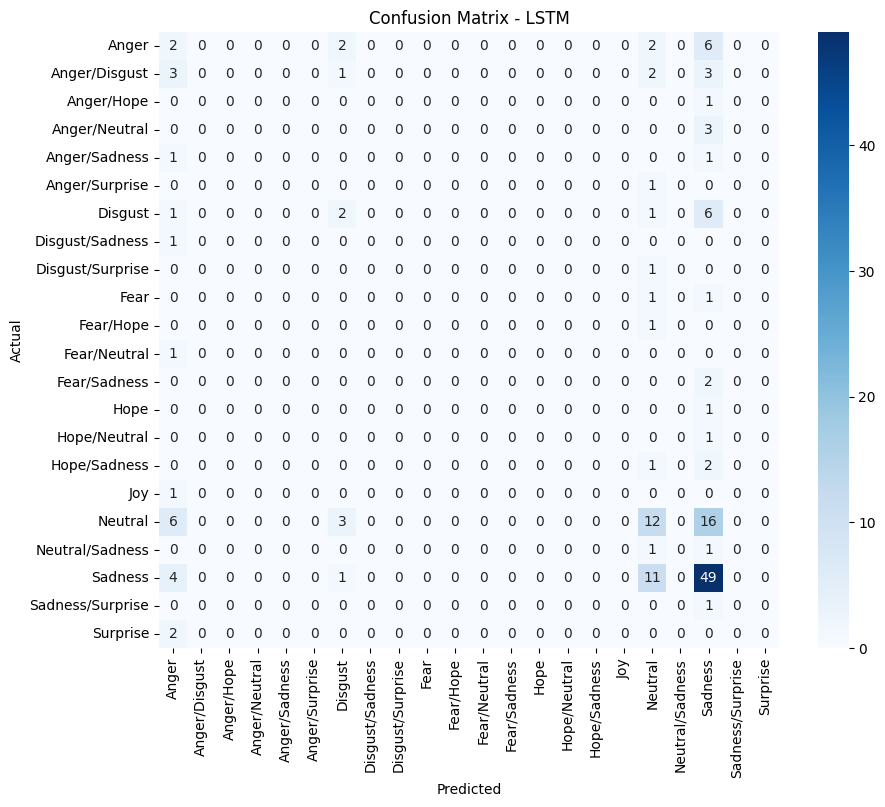

In [65]:

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_val_true_classes, y_val_pred_lstm_classes)

# Plot confusion matrix with emotion labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_labels, yticklabels=filtered_labels)
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()